## Modeling

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
chefmozaccepts = pd.read_csv('data/chefmozaccepts.csv')
chefmozcuisine = pd.read_csv('data/chefmozcuisine.csv')
chefmozhours4 = pd.read_csv('data/chefmozhours4.csv')
chefmozparking = pd.read_csv('data/chefmozparking.csv')
geoplaces2 = pd.read_csv('data/geoplaces2.csv', encoding='ISO-8859-1')  # Correctly loaded with ISO-8859-1 encoding
rating_final = pd.read_csv('data/rating_final.csv')
usercuisine = pd.read_csv('data/usercuisine.csv')
userpayment = pd.read_csv('data/userpayment.csv')
userprofile = pd.read_csv('data/userprofile.csv')

## Data Cleaning

In [3]:
# Aggregating 'Rpayment' from chefmozaccepts by placeID
payments_agg = chefmozaccepts.groupby('placeID')['Rpayment'].apply(list).reset_index()

# Aggregating 'Rcuisine' from chefmozcuisine by placeID
cuisine_agg = chefmozcuisine.groupby('placeID')['Rcuisine'].apply(list).reset_index()

# Aggregating 'parking_lot' from chefmozparking by placeID
parking_agg = chefmozparking.groupby('placeID')['parking_lot'].apply(list).reset_index()

# Now, merge these aggregated datasets with geoplaces2 on 'placeID'
restaurant= geoplaces2.merge(payments_agg, on='placeID', how='left')\
                          .merge(cuisine_agg, on='placeID', how='left')\
                          .merge(parking_agg, on='placeID', how='left')

# Display the first few rows of the combined restaurant-related DataFrame
restaurant.head()

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,...,accessibility,price,url,Rambience,franchise,area,other_services,Rpayment,Rcuisine,parking_lot
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,...,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none,NaN,[Japanese],[none]
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,...,completely,low,?,familiar,f,open,none,[cash],[Mexican],[none]
2,135106,22.149709,-100.976093,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rincón de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,...,partially,medium,?,familiar,f,open,none,"[cash, VISA, MasterCard-Eurocard]",[Mexican],[none]
3,132667,23.752697,-99.163359,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,...,completely,low,?,familiar,t,closed,none,[cash],[Armenian],[none]
4,132613,23.752903,-99.165076,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,...,completely,medium,?,familiar,t,closed,none,[cash],[Mexican],[yes]


In [4]:
restaurant_df = restaurant.drop(['the_geom_meter','fax', 'url', 'zip', 'address', 'country', 'city'], axis = 1)
restaurant_df.head()

,placeID,latitude,longitude,name,state,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services,Rpayment,Rcuisine,parking_lot
0,134999,18.915421,-99.184871,Kiku Cuernavaca,Morelos,No_Alcohol_Served,none,informal,no_accessibility,medium,familiar,f,closed,none,NaN,[Japanese],[none]
1,132825,22.147392,-100.983092,puesto de tacos,s.l.p.,No_Alcohol_Served,none,informal,completely,low,familiar,f,open,none,[cash],[Mexican],[none]
2,135106,22.149709,-100.976093,El Rincón de San Francisco,San Luis Potosi,Wine-Beer,only at bar,informal,partially,medium,familiar,f,open,none,"[cash, VISA, MasterCard-Eurocard]",[Mexican],[none]
3,132667,23.752697,-99.163359,little pizza Emilio Portes Gil,tamaulipas,No_Alcohol_Served,none,informal,completely,low,familiar,t,closed,none,[cash],[Armenian],[none]
4,132613,23.752903,-99.165076,carnitas_mata,Tamaulipas,No_Alcohol_Served,permitted,informal,completely,medium,familiar,t,closed,none,[cash],[Mexican],[yes]


In [5]:
# Standardize 'state' values
state_mapping = {
    'SLP': 'San Luis Potosi',
    's.l.p.': 'San Luis Potosi',
    'S.L.P.': 'San Luis Potosi',
    'slp': 'San Luis Potosi',
    'san luis potosi': 'San Luis Potosi',
    'san luis potos': 'San Luis Potosi',
    'Tamaulipas': 'Tamaulipas',
    'tamaulipas': 'Tamaulipas',
    'Morelos': 'Morelos',
    'morelos': 'Morelos',
    'mexico': 'Mexico'
    # Add other mappings as necessary
}

# Replace '?' with Unknown for clarity
restaurant_df['state'] = restaurant_df['state'].replace('?', 'Unknown')

# Replace NaN with pd.NA in specific columns
specific_columns = ['Rpayment', 'Rcuisine', 'parking_lot']
for column in specific_columns:
    restaurant_df[column] = restaurant_df[column].fillna('Unknown')
    
# For columns with list values, apply capitalization to each element in the list
list_columns = ['Rpayment', 'Rcuisine', 'parking_lot']

for col in list_columns:
    restaurant_df[col] = restaurant_df[col].apply(lambda x: [i.capitalize() for i in x] if isinstance(x, list) else x)


# Covert list to string
# Define the columns to convert from lists to comma-separated strings
columns_to_convert = ['Rcuisine', 'Rpayment', 'parking_lot']

# Loop through each specified column and apply the transformation
for column in columns_to_convert:
    new_col_name = f"{column}_str"  # Create a new column name
    restaurant_df[new_col_name] = restaurant_df[column].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

    
# Apply mapping
restaurant_df['state'] = restaurant_df['state'].apply(lambda x: state_mapping.get(x, x)).str.title()

# Capitalize the first letter of selected columns
columns_to_capitalize = ['alcohol', 'smoking_area', 'dress_code', 'accessibility', 'price', 'Rambience', 'franchise', 'area', 'other_services', 'Rcuisine_str', 'Rpayment_str', 'parking_lot_str']

for col in columns_to_capitalize:
    restaurant_df[col] = restaurant_df[col].str.capitalize()

# Drop duplicate columns
restaurant_df = restaurant_df.drop(['Rpayment', 'Rcuisine', 'parking_lot'], axis = 1)

restaurant_df.head()

,placeID,latitude,longitude,name,state,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services,Rcuisine_str,Rpayment_str,parking_lot_str
0,134999,18.915421,-99.184871,Kiku Cuernavaca,Morelos,No_alcohol_served,None,Informal,No_accessibility,Medium,Familiar,F,Closed,None,Japanese,Unknown,None
1,132825,22.147392,-100.983092,puesto de tacos,San Luis Potosi,No_alcohol_served,None,Informal,Completely,Low,Familiar,F,Open,None,Mexican,Cash,None
2,135106,22.149709,-100.976093,El Rincón de San Francisco,San Luis Potosi,Wine-beer,Only at bar,Informal,Partially,Medium,Familiar,F,Open,None,Mexican,"Cash, visa, mastercard-eurocard",None
3,132667,23.752697,-99.163359,little pizza Emilio Portes Gil,Tamaulipas,No_alcohol_served,None,Informal,Completely,Low,Familiar,T,Closed,None,Armenian,Cash,None
4,132613,23.752903,-99.165076,carnitas_mata,Tamaulipas,No_alcohol_served,Permitted,Informal,Completely,Medium,Familiar,T,Closed,None,Mexican,Cash,Yes


In [6]:
# Combine User-related Data
# Aggregating 'Rcuisine' from usercuisine by userID
user_cuisine_agg = usercuisine.groupby('userID')['Rcuisine'].apply(list).reset_index()

# Aggregating 'Upayment' from userpayment by userID
user_payment_agg = userpayment.groupby('userID')['Upayment'].apply(list).reset_index()

# Merge these aggregated datasets with userprofile on 'userID'
user_df = userprofile.merge(user_cuisine_agg, on='userID', how='left')\
                     .merge(user_payment_agg, on='userID', how='left')

# Display the first few rows of the combined user-related DataFrame
user_df.head()

# Capitalize the first letter of selected columns
columns_to_capitalize = ['smoker', 'drink_level', 'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
                         'interest', 'personality', 'religion', 'activity', 'color', 'budget']

for col in columns_to_capitalize:
    user_df[col] = user_df[col].str.capitalize()

# For columns with list values, apply capitalization to each element in the list
list_columns = ['Upayment', 'Rcuisine']

for col in list_columns:
    user_df[col] = user_df[col].apply(lambda x: [i.capitalize() for i in x] if isinstance(x, list) else x)
    

# Replace '?' with Unknown for clarity
columns = ['smoker', 'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos', 'activity', 'budget']

for col in columns:
    user_df[col] = user_df[col].replace('?', 'Unknown')
    
    
# Covert list to string
# Define the columns to convert from lists to comma-separated strings
columns_to_convert = ['Rcuisine', 'Upayment']

# Loop through each specified column and apply the transformation
for column in columns_to_convert:
    new_col_name = f"{column}_str"  # Create a new column name
    user_df[new_col_name] = user_df[column].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Drop duplicate columns
user_df = user_df.drop(['Rcuisine', 'Upayment'], axis = 1)

user_df.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,...,interest,personality,religion,activity,color,weight,budget,height,Rcuisine_str,Upayment_str
0,U1001,22.139997,-100.978803,False,Abstemious,Informal,Family,On foot,Single,Independent,...,Variety,Thrifty-protector,None,Student,Black,69,Medium,1.77,American,Cash
1,U1002,22.150087,-100.983325,False,Abstemious,Informal,Family,Public,Single,Independent,...,Technology,Hunter-ostentatious,Catholic,Student,Red,40,Low,1.87,Mexican,Cash
2,U1003,22.119847,-100.946527,False,Social drinker,Formal,Family,Public,Single,Independent,...,None,Hard-worker,Catholic,Student,Blue,60,Low,1.69,Mexican,Cash
3,U1004,18.867000,-99.183000,False,Abstemious,Informal,Family,Public,Single,Independent,...,Variety,Hard-worker,None,Professional,Green,44,Medium,1.53,"Bakery, Breakfast-brunch, Japanese, Contempora...","Cash, Bank_debit_cards"
4,U1005,22.183477,-100.959891,False,Abstemious,No preference,Family,Public,Single,Independent,...,None,Thrifty-protector,Catholic,Student,Black,65,Medium,1.69,American,Cash


## Clusters of Users
#### feature selection: 
* Demographic Information (marital_status, hijos, birth_year): Might be less relevant unless you have specific insights about their relationship to restaurant preferences.
* Personal Attributes (interest, personality, religion, activity): These might be relevant if you think they could relate to the type of restaurants a user might prefer.
* Physical Attributes (color, weight, height): These are typically less relevant unless you have a specific hypothesis about how they might relate to dining preferences.

In [7]:
X = userprofile.drop("userID", axis = 1)

## Demographic Clusters (K-Prototype)

In [8]:
demo_features = ['latitude','longitude','ambience','transport', 'marital_status', 'hijos', 'birth_year', 'activity']
X_demo = X[demo_features]

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Scale numerical variables
scaler = StandardScaler()
X_demo[['latitude', 'longitude', 'birth_year']] = scaler.fit_transform(X_demo[['latitude', 'longitude', 'birth_year']])

/var/folders/x7/1lss9g1950lgrxkwhp8c6c180000gn/T/ipykernel_7392/3197948488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_demo[['latitude', 'longitude', 'birth_year']] = scaler.fit_transform(X_demo[['latitude', 'longitude', 'birth_year']])


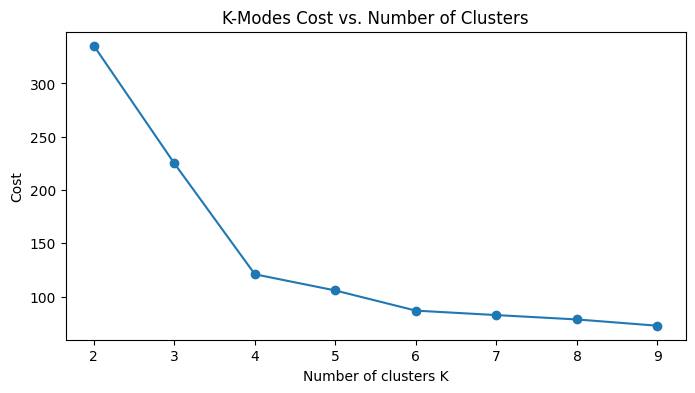

In [10]:
from kmodes.kprototypes import KPrototypes
categorical_columns = ['ambience', 'transport', 'marital_status', 'hijos', 'activity']
# Specify the indices of categorical variables for K-Prototypes
categorical_indices = [X_demo.columns.get_loc(col) for col in categorical_columns]

# Determine the optimal number of clusters using the Elbow method
costs = []
K_range = range(2, 10)  

for k in K_range:
    kproto = KPrototypes(n_clusters=k, init='Cao')
    kproto.fit_predict(X_demo, categorical=categorical_indices)
    costs.append(kproto.cost_)
    
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of clusters K')
plt.ylabel('Cost')
plt.title('K-Modes Cost vs. Number of Clusters')
plt.show()

In [11]:
from sklearn.metrics import silhouette_score

best_kproto = KPrototypes(n_clusters=4, init='Cao')
kproto_clusters = best_kproto.fit_predict(X_demo, categorical=categorical_indices)
X_demo_k_cluster = X_demo.copy()

In [12]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(X_demo_k_cluster[categorical_columns])

# Create a DataFrame with the encoded data
# This will have one column for each category value of the original data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

# Drop the original categorical columns from df
X_demo_k_cluster = X_demo_k_cluster.drop(categorical_columns, axis=1)

# Concatenate the original DataFrame 'df' with the new 'encoded_df'
X_demo_k_cluster = pd.concat([X_demo_k_cluster, encoded_df], axis=1)

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Use t-SNE to reduce dimensionality and visiualization

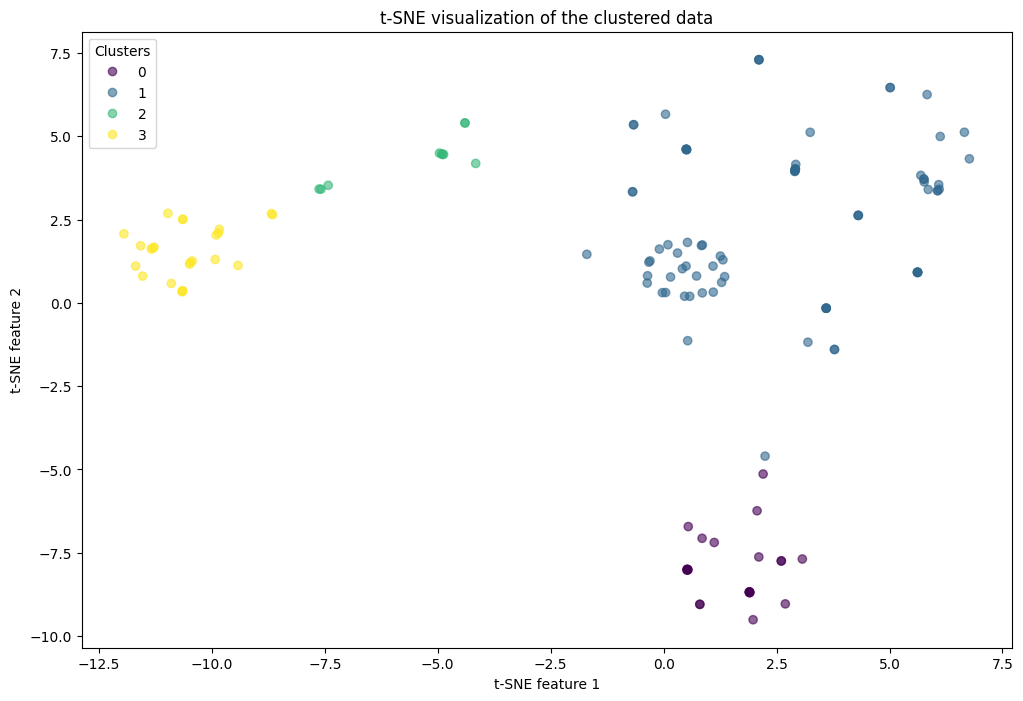

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30.0, random_state=42)
X_tsne = tsne.fit_transform(X_demo_k_cluster)

# Plot the results in a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kproto_clusters, cmap='viridis', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('t-SNE visualization of the clustered data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [14]:
X_demo

,latitude,longitude,ambience,transport,marital_status,hijos,birth_year,activity
0,0.213077,-0.792545,family,on foot,single,independent,0.294278,student
1,0.219600,-0.797763,family,public,single,independent,0.362761,student
2,0.200051,-0.755308,family,public,single,independent,0.294278,student
3,-1.902775,1.279315,family,public,single,independent,-3.061388,professional
4,0.241185,-0.770726,family,public,single,independent,0.499727,student
...,...,...,...,...,...,...,...,...
133,0.219320,-0.815397,family,public,single,independent,0.431244,student
134,0.232729,-0.759241,family,on foot,single,kids,0.225795,student
135,0.219290,-0.813811,friends,car owner,single,independent,0.362761,student
136,0.216184,-0.753111,family,public,single,independent,0.294278,student


In [15]:
kproto_clusters

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 3, 1, 0, 1, 1, 3, 1, 1, 3, 0, 1,
       0, 2, 1, 0, 1, 0, 1, 3, 0, 1, 1, 1, 3, 1, 1, 2, 0, 3, 3, 2, 0, 3,
       1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 2, 2, 1, 1, 3, 0, 1, 1, 0, 1, 0, 3,
       0, 0, 3, 0, 2, 3, 1, 3, 1, 1, 1, 1, 3, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 2, 0, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 3, 2, 0, 1, 1, 1, 3, 1, 0, 0, 1, 1,
       3, 1, 1, 1, 1, 1], dtype=uint16)

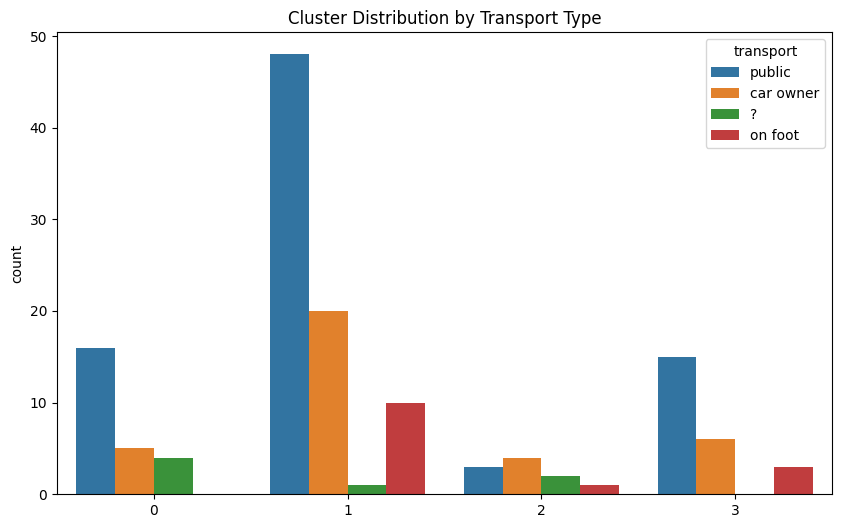

In [16]:
# Here is how you could create a clustered bar chart for the 'transport' variable:
plt.figure(figsize=(10, 6))
sns.countplot(x=kproto_clusters, hue=X_demo.transport)
plt.title('Cluster Distribution by Transport Type')
plt.show()

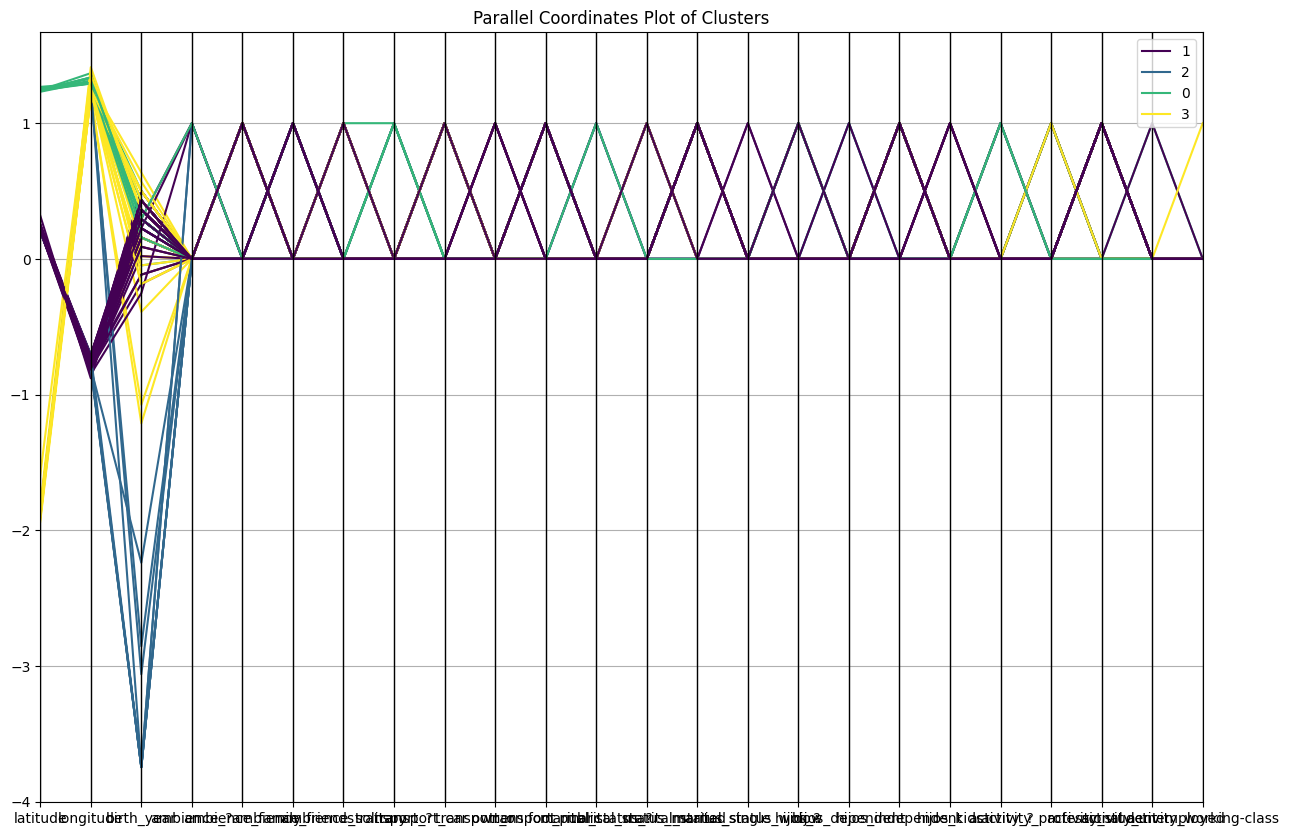

In [17]:
from pandas.plotting import parallel_coordinates

X_demo_k_cluster["cluster"] = kproto_clusters

plt.figure(figsize=(15, 10))
parallel_coordinates(X_demo_k_cluster, class_column="cluster", colormap='viridis')
plt.title('Parallel Coordinates Plot of Clusters')
plt.show()

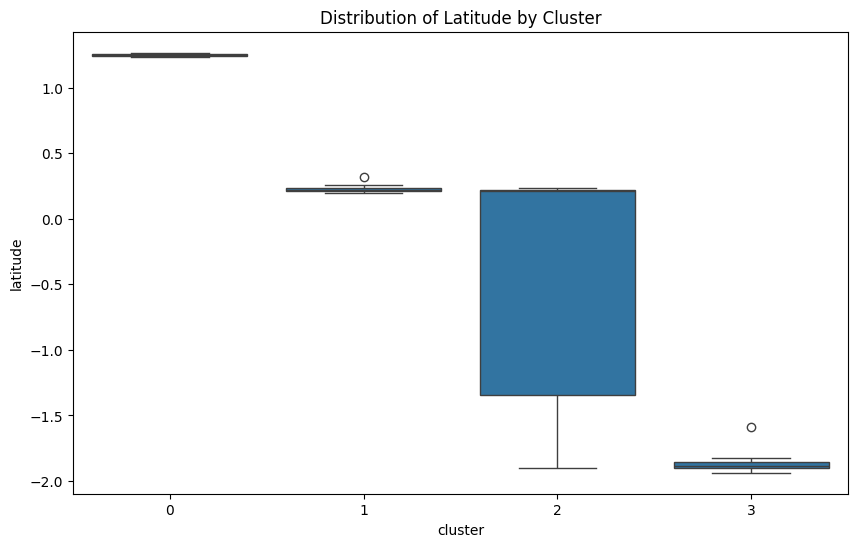

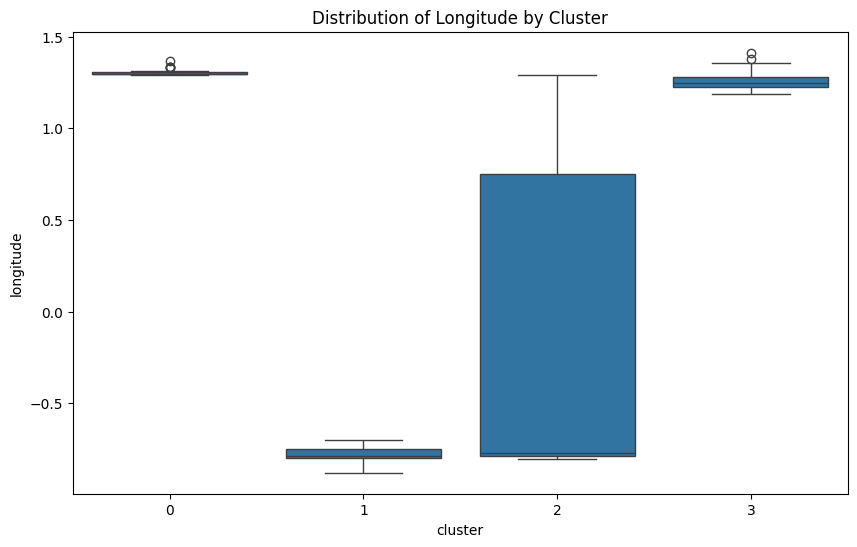

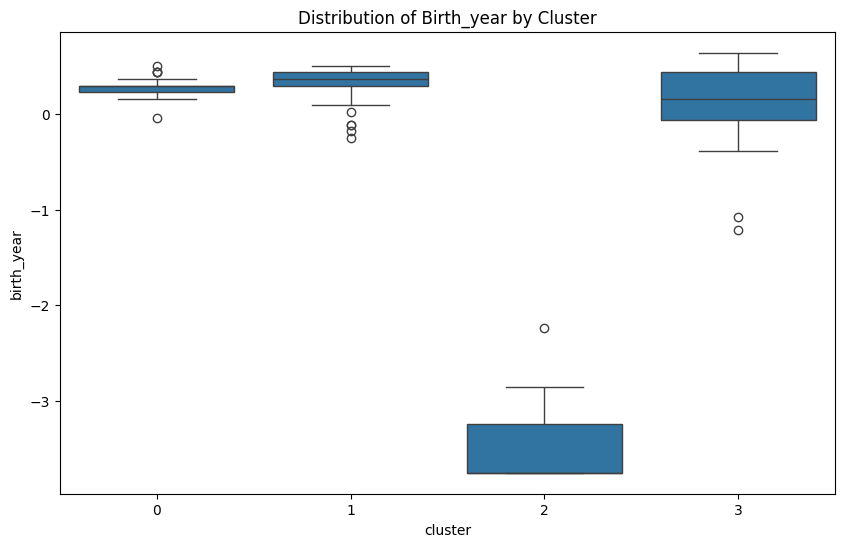

In [18]:
continuous_vars = ['latitude', 'longitude', 'birth_year']

for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=var, data=X_demo_k_cluster)
    plt.title(f'Distribution of {var.capitalize()} by Cluster')
    plt.show()

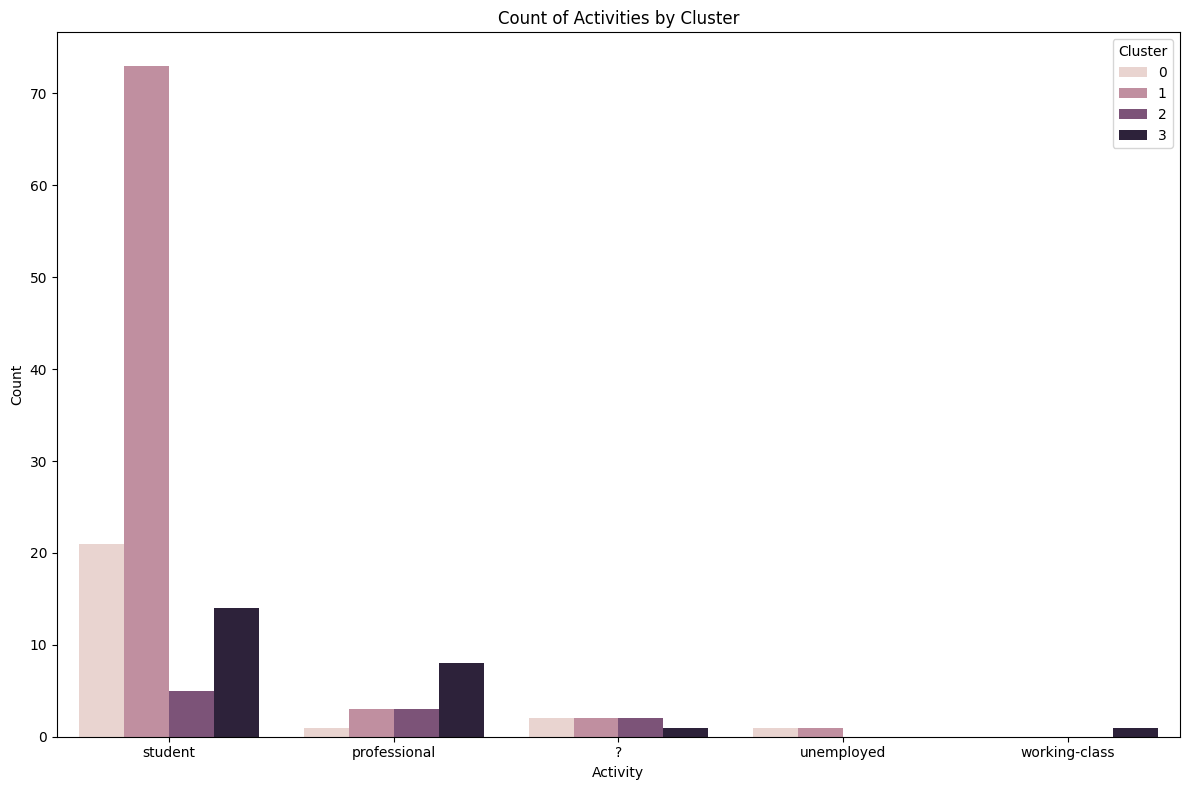

In [19]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='activity', hue=kproto_clusters, data=X_demo)
ax.set_title('Count of Activities by Cluster')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

## Personal Attributes Clusters (Kmodes)

In [20]:
X_person = X[['smoker', 'drink_level', 'dress_preference','interest', 'personality']]

In [22]:
X.personality

0        thrifty-protector
1      hunter-ostentatious
2              hard-worker
3              hard-worker
4        thrifty-protector
              ...         
133            hard-worker
134    hunter-ostentatious
135      thrifty-protector
136            hard-worker
137      thrifty-protector
Name: personality, Length: 138, dtype: object

## The plot does not have an elbow, so I will be switching to another algorithms (Hierachical Clusterings)

/var/folders/x7/1lss9g1950lgrxkwhp8c6c180000gn/T/ipykernel_7392/123763016.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, 'ward')


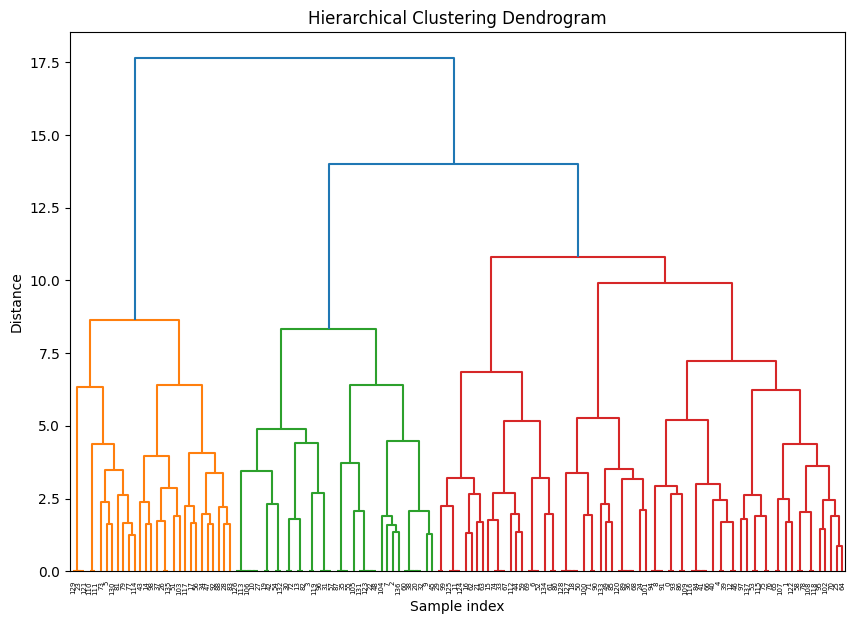

/var/folders/x7/1lss9g1950lgrxkwhp8c6c180000gn/T/ipykernel_7392/123763016.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_person['Cluster'] = clusters


In [23]:
import gower
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler


# Compute the Gower distance matrix
distance_matrix = gower.gower_matrix(X_person)

# Perform hierarchical clustering
Z = linkage(distance_matrix, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(Z)
plt.show()

# To form flat clusters from the hierarchical clustering defined by the given linkage matrix
# Choose a cutoff distance (t) to define the number of clusters
t = 2.0
clusters = fcluster(Z, t, criterion='distance')

# Add cluster labels to the original dataframe
X_person['Cluster'] = clusters

In [24]:
np.unique(X_person["Cluster"])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56], dtype=int32)

## Clusterings for user profile (K-Prototype)

In [25]:
X = userprofile.drop(["userID", "color", "weight", "height"], axis = 1)

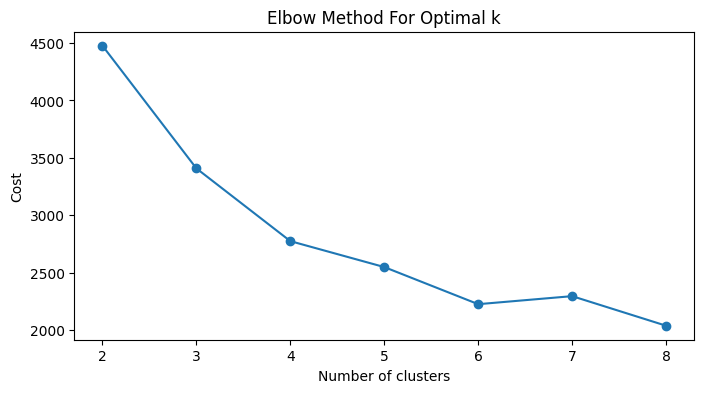

In [26]:
# Determine which columns are categorical
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns
categorical = [X.columns.get_loc(col) for col in cat_cols]

# List to hold the costs for different values of K
costs = []

# Range of K to try
K_range = range(2, 9)

for K in K_range:
    kproto = KPrototypes(n_clusters=K, init='Huang', verbose=0, random_state=1)
    kproto.fit_predict(X, categorical=categorical)
    costs.append(kproto.cost_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

## USE TSNE to visualize the clusterings

In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(X[cat_cols])

# Create a DataFrame with the encoded data
# This will have one column for each category value of the original data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

# Drop the original categorical columns from df
X_viz = X.drop(cat_cols, axis=1)

# Concatenate the original DataFrame 'df' with the new 'encoded_df'
X_viz = pd.concat([X_viz, encoded_df], axis=1)

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


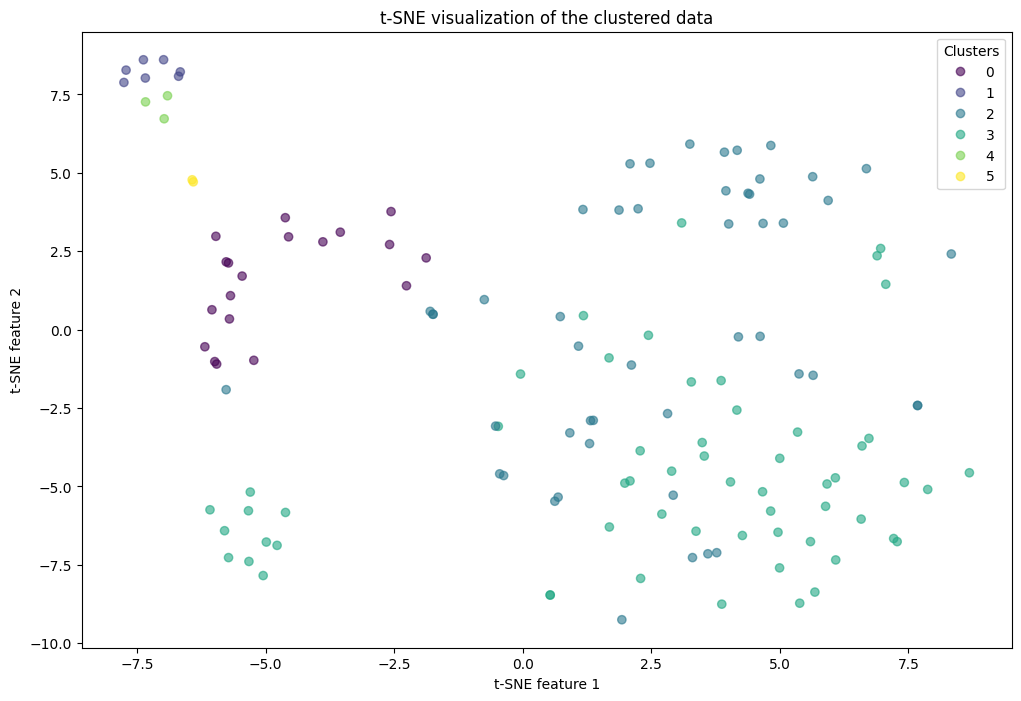

In [28]:
from sklearn.manifold import TSNE

elbow_kproto = KPrototypes(n_clusters=6, init='Huang', verbose=0, random_state=1)
kproto_clusters = elbow_kproto.fit_predict(X, categorical=categorical)

tsne = TSNE(n_components=2, perplexity=30.0, random_state=42)
X_tsne = tsne.fit_transform(X_viz)

# Plot the results in a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kproto_clusters, cmap='viridis', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('t-SNE visualization of the clustered data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [29]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

def plot_silhouette(df, cluster_labels, feature_cols):
    """
    Create a silhouette plot given a dataframe of features and corresponding cluster labels.

    Parameters:
    - df : pandas DataFrame containing the features used for clustering.
    - cluster_labels : array or list of cluster labels corresponding to the data points in df.
    - feature_cols : list of column names in df that were used for clustering.
    """
    # Subset the dataframe to only use the specified features for silhouette calculation
    X = df[feature_cols].values
    
    # Calculate the silhouette scores for each sample
    silhouette_vals = silhouette_samples(X, cluster_labels)
    
    # Compute the average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f'Average silhouette score: {silhouette_avg}')
    
    # Number of clusters
    n_clusters = len(np.unique(cluster_labels))
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([i/10.0 for i in range(-1, 11)])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

Average silhouette score: 0.15893369752842876


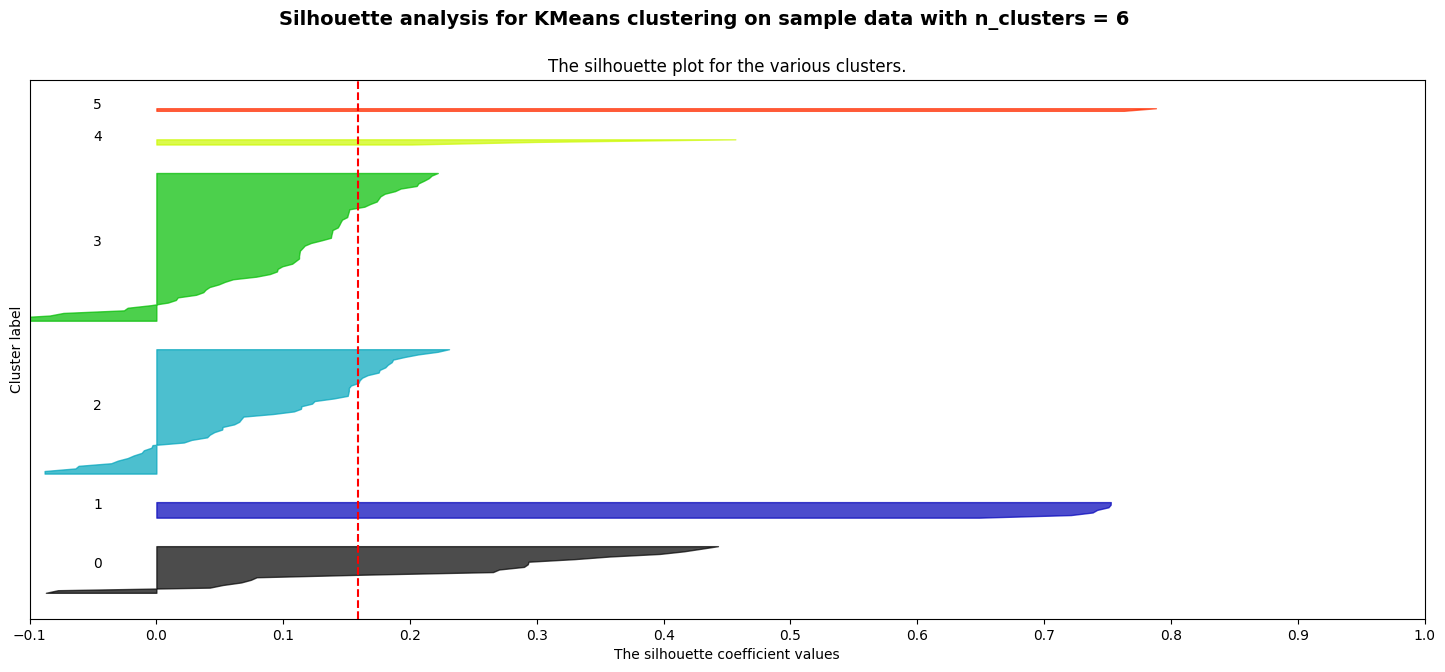

In [30]:
plot_silhouette(X_viz, kproto_clusters, X_viz.columns)

## Clusterings for user profile (DBSCAN) Too many labels

In [31]:
from sklearn.cluster import DBSCAN
# Range of values for the parameters
eps_values = np.arange(0.1, 2.0, 0.1)
min_samples_values = range(1, 30)

best_eps = None
best_min_samples = None
best_silhouette = -1

# Search for the best parameters
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_viz)
        
        # Silhouette score requires more than one cluster to be meaningful
        # -1 is the label for noise in DBSCAN
        if len(set(labels)) > 1 and np.min(labels) != -1:
            silhouette = silhouette_score(X_viz, labels)
            if silhouette > best_silhouette:
                best_eps = eps
                best_min_samples = min_samples
                best_silhouette = silhouette

print(f'Best eps: {best_eps}')
print(f'Best min_samples: {best_min_samples}')
print(f'Best Silhouette Score: {best_silhouette}')

Best eps: 1.8000000000000003
Best min_samples: 1
Best Silhouette Score: 0.11169328599958002


In [32]:
dbscan = DBSCAN(eps=1.8000000000000003, min_samples=1)
db_labels = dbscan.fit_predict(X_viz)
np.unique(db_labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117])

## GMM Clusterings 

In [33]:
from sklearn.mixture import GaussianMixture

# Set the range for the number of components (clusters) to try
n_components_range = range(2, 11)

# Storage for the best model and silhouette score
best_gmm = None
best_silhouette = -1
best_n_components = 0

# Try GMM with different numbers of components to find the best model
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm_labels = gmm.fit_predict(X_viz)
    
    # Calculate the silhouette score if more than one cluster exists
    if len(set(gmm_labels)) > 1:
        silhouette_avg = silhouette_score(X_viz, gmm_labels)
        print(f'Number of clusters: {n_components} - Silhouette Score: {silhouette_avg}')
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_gmm = gmm
            best_n_components = n_components

print(f'Best Silhouette Score: {best_silhouette}')
print(f'Optimal number of clusters: {best_n_components}')

Number of clusters: 2 - Silhouette Score: 0.8838392320011098
Number of clusters: 3 - Silhouette Score: 0.5244271392575356
Number of clusters: 4 - Silhouette Score: 0.3833735026924575
Number of clusters: 5 - Silhouette Score: 0.3837321889905358
Number of clusters: 6 - Silhouette Score: 0.16488731257863823
Number of clusters: 7 - Silhouette Score: 0.22769719186169182
Number of clusters: 8 - Silhouette Score: 0.1664293453385765
Number of clusters: 9 - Silhouette Score: 0.175098839882914
Number of clusters: 10 - Silhouette Score: 0.18316759887541195
Best Silhouette Score: 0.8838392320011098
Optimal number of clusters: 2


Average silhouette score: 0.3833735026924575


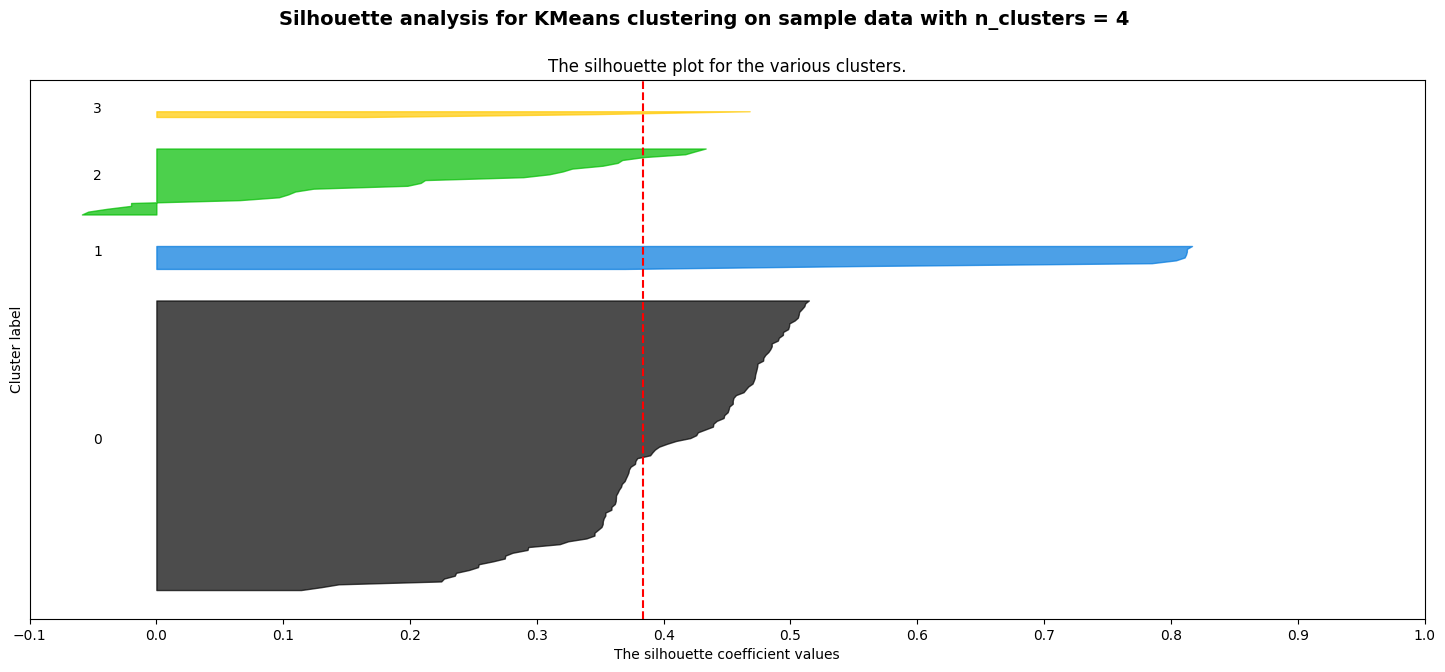

In [34]:
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X_viz)
plot_silhouette(X_viz, gmm_labels, X_viz.columns)

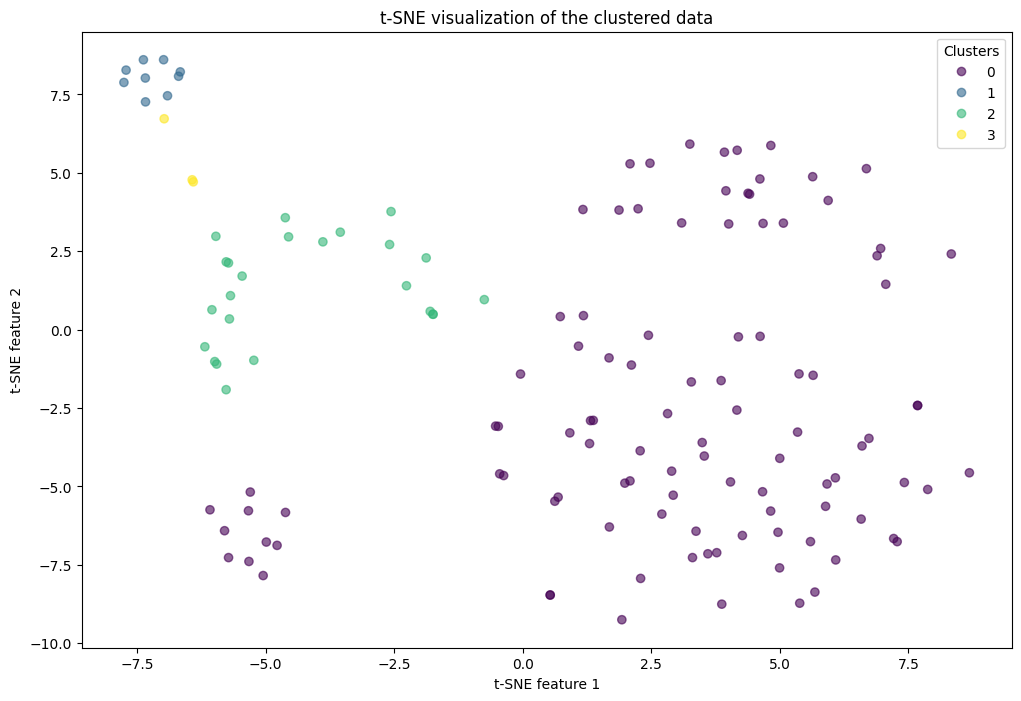

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30.0, random_state=42)
X_tsne = tsne.fit_transform(X_viz)

# Plot the results in a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('t-SNE visualization of the clustered data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [36]:
## It looks like GMM has seperated them better 

## Restaurant Clusterings (KPrototype)

In [37]:
X = restaurant_df.drop(["placeID","Rpayment_str", "parking_lot_str", "other_services"], axis = 1)

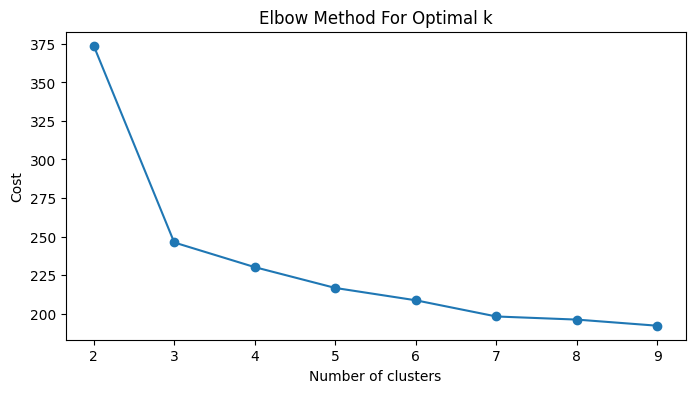

In [38]:
# Determine which columns are categorical

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns
categorical = [X.columns.get_loc(col) for col in cat_cols]


# Scale numerical variables
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# List to hold the costs for different values of K
costs = []

# Range of K to try
K_range = range(2, 10)

for K in K_range:
    kproto = KPrototypes(n_clusters=K, init='Huang', verbose=0, random_state=1)
    kproto.fit_predict(X, categorical=categorical)
    costs.append(kproto.cost_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [39]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(X[cat_cols])

# Create a DataFrame with the encoded data
# This will have one column for each category value of the original data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

# Drop the original categorical columns from df
X_viz = X.drop(cat_cols, axis=1)

# Concatenate the original DataFrame 'df' with the new 'encoded_df'
X_viz = pd.concat([X_viz, encoded_df], axis=1)

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


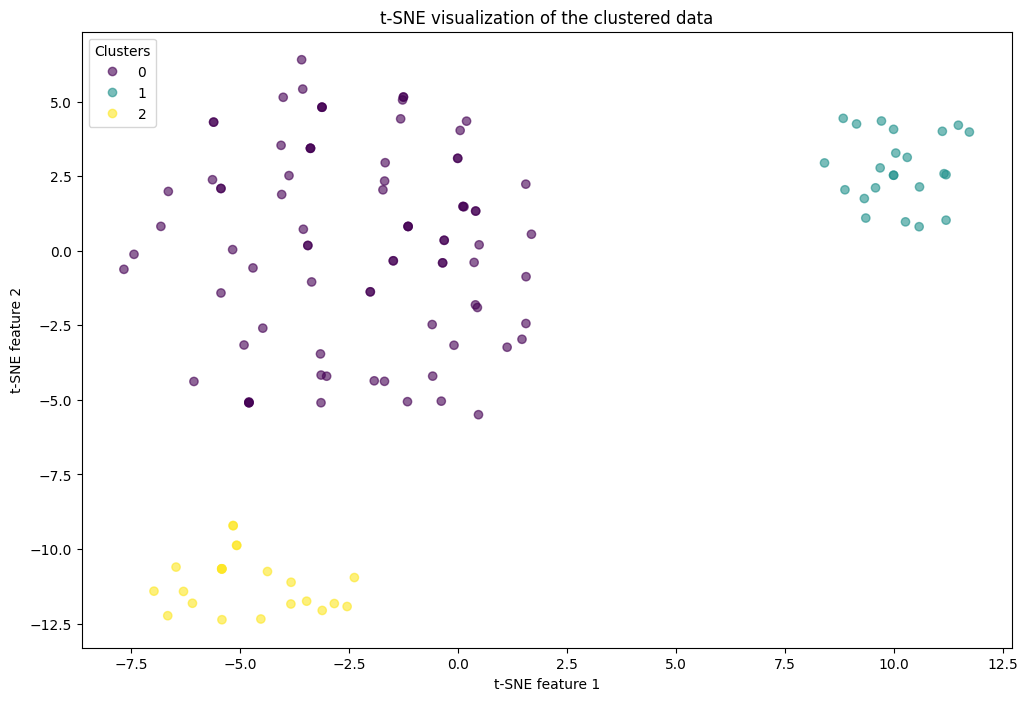

In [40]:
from sklearn.manifold import TSNE

elbow_kproto = KPrototypes(n_clusters=3, init='Huang', verbose=0, random_state=1)
kproto_clusters = elbow_kproto.fit_predict(X, categorical=categorical)

tsne = TSNE(n_components=2, perplexity=30.0, random_state=42)
X_tsne = tsne.fit_transform(X_viz)

# Plot the results in a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kproto_clusters, cmap='viridis', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('t-SNE visualization of the clustered data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

Average silhouette score: 0.27492281749834313


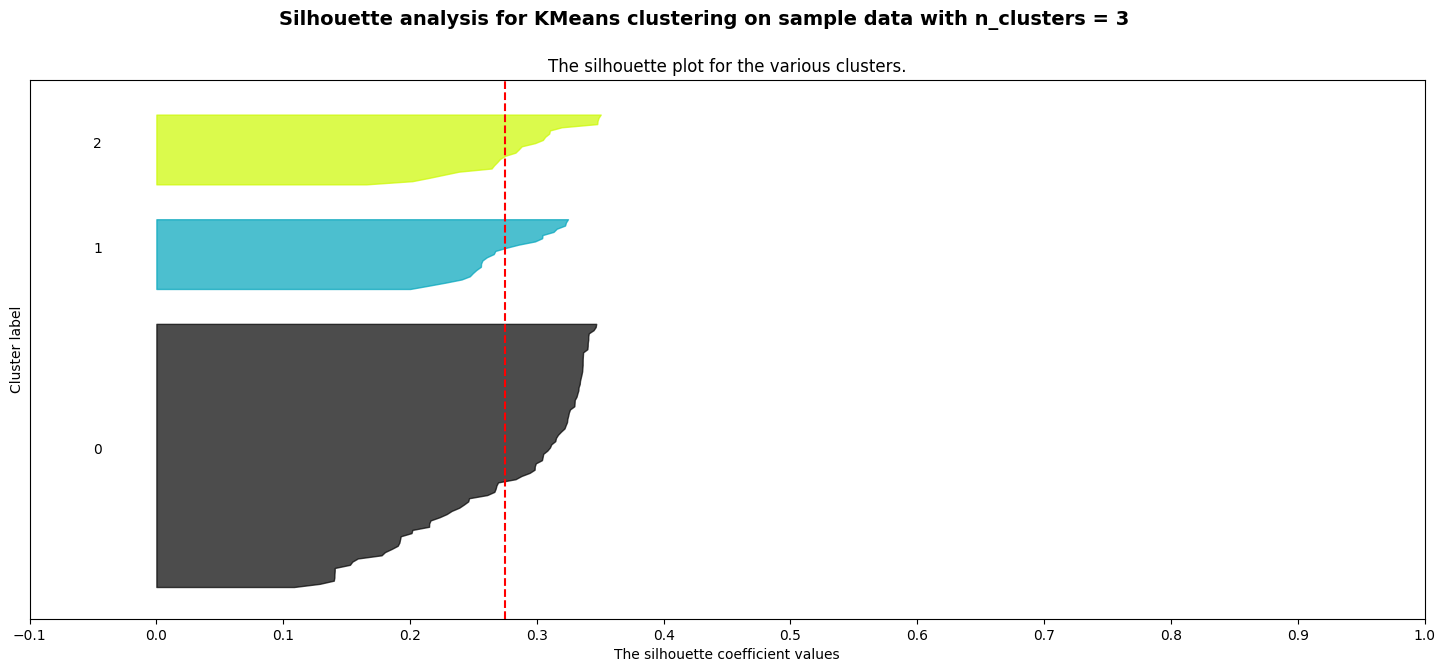

In [41]:
plot_silhouette(X_viz, kproto_clusters, X_viz.columns)

## I do not think DBscan will be useful at all over here.

In [42]:
# Set the range for the number of components (clusters) to try
n_components_range = range(2, 11)

# Storage for the best model and silhouette score
best_gmm = None
best_silhouette = -1
best_n_components = 0

# Try GMM with different numbers of components to find the best model
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm_labels = gmm.fit_predict(X_viz)
    
    # Calculate the silhouette score if more than one cluster exists
    if len(set(gmm_labels)) > 1:
        silhouette_avg = silhouette_score(X_viz, gmm_labels)
        print(f'Number of clusters: {n_components} - Silhouette Score: {silhouette_avg}')
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_gmm = gmm
            best_n_components = n_components

print(f'Best Silhouette Score: {best_silhouette}')
print(f'Optimal number of clusters: {best_n_components}')

Number of clusters: 2 - Silhouette Score: 0.25778547341652075
Number of clusters: 3 - Silhouette Score: 0.27492281749834313
Number of clusters: 4 - Silhouette Score: 0.24323166410401698
Number of clusters: 5 - Silhouette Score: 0.1620298910980153
Number of clusters: 6 - Silhouette Score: 0.12605182925674344
Number of clusters: 7 - Silhouette Score: 0.09918984998836773
Number of clusters: 8 - Silhouette Score: 0.07396197792348716
Number of clusters: 9 - Silhouette Score: 0.08714601520688027
Number of clusters: 10 - Silhouette Score: 0.08961539873882453
Best Silhouette Score: 0.27492281749834313
Optimal number of clusters: 3


Average silhouette score: 0.27492281749834313


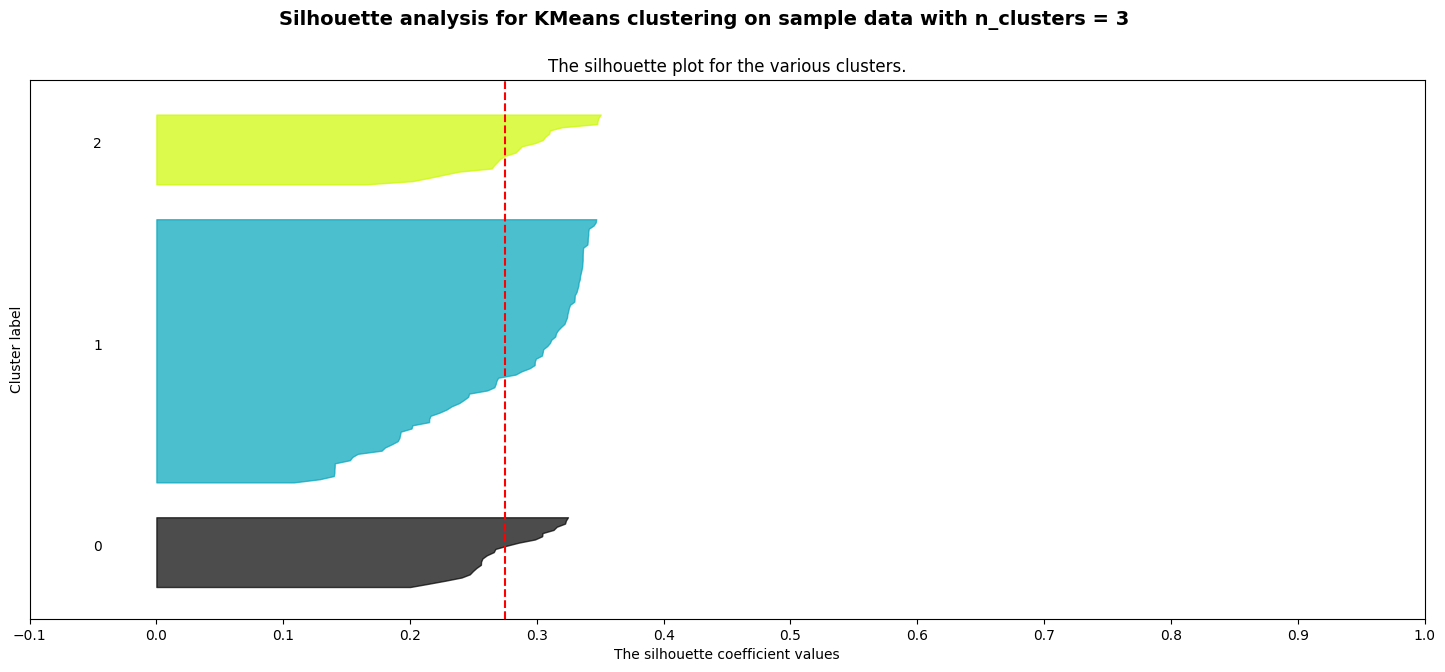

In [43]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_viz)
plot_silhouette(X_viz, gmm_labels, X_viz.columns)

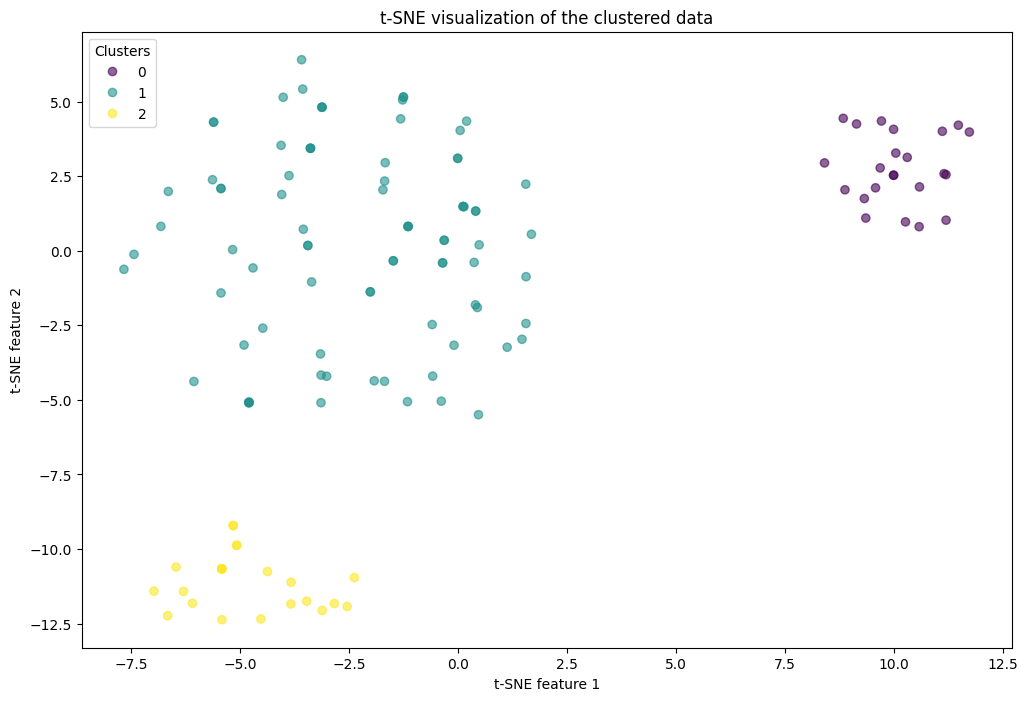

In [44]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30.0, random_state=42)
X_tsne = tsne.fit_transform(X_viz)

# Plot the results in a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('t-SNE visualization of the clustered data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

## It is the same clustering method of restaurants for GMM and K_prototype

## Understand the meaning of clusterings

In [45]:
restaurant_cluster = X.copy()
restaurant_cluster["cluster"] = gmm_labels

## Price distribution for each cluster

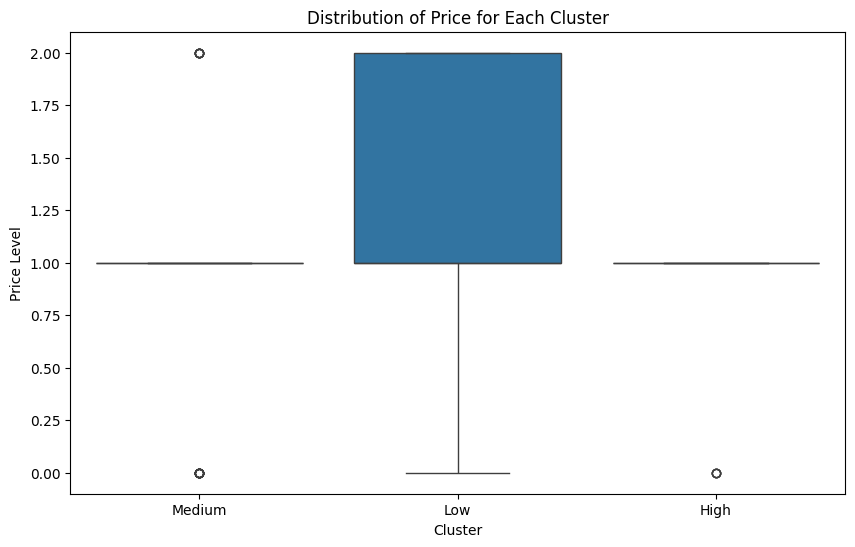

In [46]:
# Visualize the distribution of 'price' for each 'cluster'
plt.figure(figsize=(10, 6))
sns.boxplot(x='price', y='cluster', data=restaurant_cluster)
plt.title('Distribution of Price for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Price Level')
plt.show()

## dress code distribution for each cluster

In [47]:
# First, calculate the counts of each dress code within each cluster
dress_code_counts = restaurant_cluster.groupby('cluster')['dress_code'].value_counts().unstack(fill_value=0)

dress_code_counts

dress_code,Casual,Formal,Informal
cluster,,,
0,3,1,19
1,6,1,77
2,1,0,22


## goegraphic position and cluster (it looks like it mainly uses the geographic position to do the clustering)

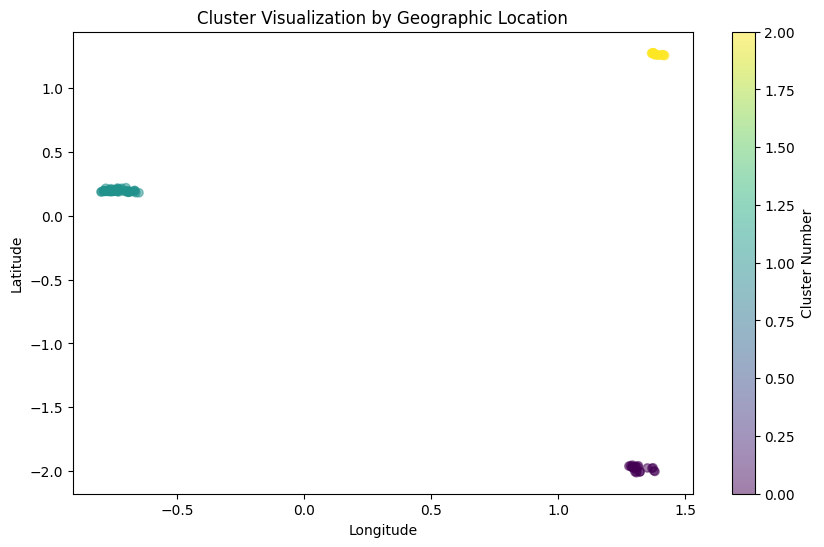

In [48]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
scatter = plt.scatter(restaurant_cluster['longitude'], restaurant_cluster['latitude'], c=restaurant_cluster['cluster'], cmap='viridis', alpha=0.5)
plt.title('Cluster Visualization by Geographic Location')  # Add a title to the plot
plt.xlabel('Longitude')  # Label the x-axis
plt.ylabel('Latitude')  # Label the y-axis

# Create a colorbar to show the cluster numbers
plt.colorbar(scatter, label='Cluster Number')

# Display the plot
plt.show()

## We drop the geographic information to cluster it again

In [51]:
X = X.drop(["longitude", "latitude"], axis = 1)

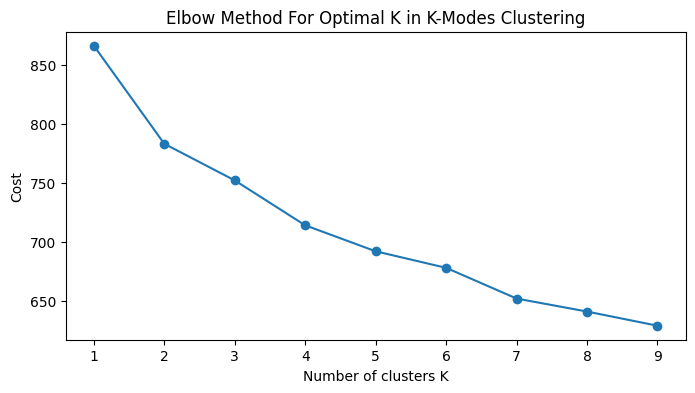

In [55]:
from kmodes.kmodes import KModes

K_range = range(1, 10)

costs = []

for K in K_range:
    km = KModes(n_clusters=K, init='Huang', n_init=5, verbose=0)
    km.fit(restaurant_cluster)
    costs.append(km.cost_)

# Plotting the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of clusters K')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal K in K-Modes Clustering')
plt.show()

## there seems to be no elbow position in the grpah

In [59]:
X_viz = X_viz.drop(["latitude", "longitude"], axis  =1 )

## this is for GMM

In [60]:
from sklearn.mixture import GaussianMixture

# Set the range for the number of components (clusters) to try
n_components_range = range(2, 11)

# Storage for the best model and silhouette score
best_gmm = None
best_silhouette = -1
best_n_components = 0

# Try GMM with different numbers of components to find the best model
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm_labels = gmm.fit_predict(X_viz)
    
    # Calculate the silhouette score if more than one cluster exists
    if len(set(gmm_labels)) > 1:
        silhouette_avg = silhouette_score(X_viz, gmm_labels)
        print(f'Number of clusters: {n_components} - Silhouette Score: {silhouette_avg}')
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_gmm = gmm
            best_n_components = n_components

print(f'Best Silhouette Score: {best_silhouette}')
print(f'Optimal number of clusters: {best_n_components}')

Number of clusters: 2 - Silhouette Score: 0.09022816712598791
Number of clusters: 3 - Silhouette Score: 0.1292425624393608
Number of clusters: 4 - Silhouette Score: 0.0992145179793942
Number of clusters: 5 - Silhouette Score: 0.10434315107382294
Number of clusters: 6 - Silhouette Score: 0.0899068583830232
Number of clusters: 7 - Silhouette Score: 0.10256495734953995
Number of clusters: 8 - Silhouette Score: 0.09449265312476458
Number of clusters: 9 - Silhouette Score: 0.09201539328864304
Number of clusters: 10 - Silhouette Score: 0.09355992034248835
Best Silhouette Score: 0.1292425624393608
Optimal number of clusters: 3


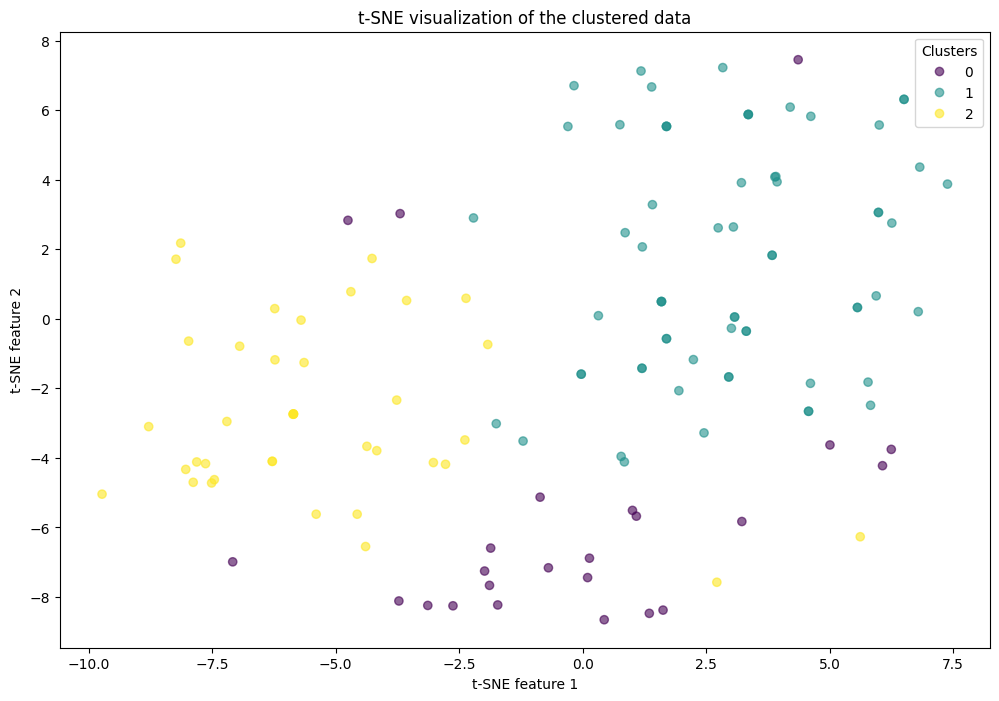

In [62]:
from sklearn.manifold import TSNE

gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_viz)

tsne = TSNE(n_components=2, perplexity=30.0, random_state=42)
X_tsne = tsne.fit_transform(X_viz)

# Plot the results in a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('t-SNE visualization of the clustered data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [63]:
restaurant_no_geo = X.copy()
restaurant_no_geo["cluster"] = gmm_labels

In [64]:
restaurant_no_geo 

,name,state,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,Rcuisine_str,cluster
0,Kiku Cuernavaca,Morelos,No_alcohol_served,None,Informal,No_accessibility,Medium,Familiar,F,Closed,Japanese,1
1,puesto de tacos,San Luis Potosi,No_alcohol_served,None,Informal,Completely,Low,Familiar,F,Open,Mexican,2
2,El Rincón de San Francisco,San Luis Potosi,Wine-beer,Only at bar,Informal,Partially,Medium,Familiar,F,Open,Mexican,1
3,little pizza Emilio Portes Gil,Tamaulipas,No_alcohol_served,None,Informal,Completely,Low,Familiar,T,Closed,Armenian,2
4,carnitas_mata,Tamaulipas,No_alcohol_served,Permitted,Informal,Completely,Medium,Familiar,T,Closed,Mexican,0
...,...,...,...,...,...,...,...,...,...,...,...,...
125,Chaires,San Luis Potosi,No_alcohol_served,Not permitted,Informal,Completely,Medium,Familiar,F,Closed,"Bakery, cafeteria",0
126,Sushi Itto,San Luis Potosi,No_alcohol_served,None,Informal,No_accessibility,Medium,Familiar,F,Closed,Japanese,1
127,Paniroles,Unknown,Wine-beer,Not permitted,Informal,No_accessibility,Medium,Quiet,F,Closed,Italian,0
128,Restaurant Bar Coty y Pablo,Morelos,No_alcohol_served,None,Informal,Completely,Low,Familiar,F,Closed,Bar,2


In [75]:
# Visualize the distribution of 'price' for each 'cluster'
price_counts = restaurant_no_geo.groupby('cluster')['price'].value_counts().unstack(fill_value=0)

price_counts

price,High,Low,Medium
cluster,,,
0,1,2,21
1,23,5,39
2,1,38,0


In [76]:
# Visualize the distribution of 'price' for each 'cluster'
price_counts = restaurant_no_geo.groupby('cluster')['accessibility'].value_counts().unstack(fill_value=0)

price_counts

accessibility,Completely,No_accessibility,Partially
cluster,,,
0,11,7,6
1,3,61,3
2,31,8,0


In [81]:
# Visualize the distribution of 'price' for each 'cluster'
franchise_counts = restaurant_no_geo.groupby('cluster')['franchise'].value_counts().unstack(fill_value=0)

franchise_counts

franchise,F,T
cluster,,
0,8,16
1,66,1
2,34,5


In [83]:
# Visualize the distribution of 'price' for each 'cluster'
franchise_counts = restaurant_no_geo.groupby('cluster')['alcohol'].value_counts().unstack(fill_value=0)

franchise_counts

alcohol,Full_bar,No_alcohol_served,Wine-beer
cluster,,,
0,2,16,6
1,5,38,24
2,2,33,4


In [80]:
# First, calculate the counts of each dress code within each cluster
rambience_counts = restaurant_no_geo.groupby('cluster')['Rambience'].value_counts().unstack(fill_value=0)

rambience_counts

Rambience,Familiar,Quiet
cluster,,
0,23,1
1,66,1
2,32,7


In [69]:
# First, calculate the counts of each dress code within each cluster
state_counts = restaurant_no_geo.groupby('cluster')['state'].value_counts().unstack(fill_value=0)

state_counts

state,Mexico,Morelos,San Luis Potosi,Tamaulipas,Unknown
cluster,,,,,
0,1,8,4,4,7
1,0,8,59,0,0
2,1,4,11,12,11


## Now, based on above table, we can see that restaurants clusterings are clustered by its classy level. 